<a href="https://colab.research.google.com/github/Cool-buddies-of-ENEL645/OurAwesomeFinalProject/blob/main/ResNet50_50epocs_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import matplotlib.pylab as plt
import pickle

In [2]:
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

# Train and validation generators
train_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
val_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]

bs = 64 # batch size

train_generator = train_gen.flow_from_directory(
    directory = "/content/drive/MyDrive/Data/GarbageClassification/Garbage-dataset-pre-processed/Train",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

validation_generator = val_gen.flow_from_directory(
    directory = "/content/drive/MyDrive/Data/GarbageClassification/Garbage-dataset-pre-processed/Validation",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",)

Found 5139 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


In [3]:
model_name_it = "garbage_classifier_resnet_it.h5"
model_name_ft = "garbage_classifier_resnet_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [4]:
img_height = 256
img_width = 256

# Defining the model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)


out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 4)                 524292    
                                                                 
Total params: 24,112,004
Trainable params: 524,292
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit(train_generator, epochs=50, verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (validation_generator))

Epoch 1/50
81/81 [==============================] - 107s 1s/step - loss: 0.8511 - accuracy: 0.7758 - val_loss: 0.8960 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 2/50
81/81 [==============================] - 101s 1s/step - loss: 0.5458 - accuracy: 0.8500 - val_loss: 0.8831 - val_accuracy: 0.7979 - lr: 1.0000e-04
Epoch 3/50
81/81 [==============================] - 103s 1s/step - loss: 0.4219 - accuracy: 0.8832 - val_loss: 0.8995 - val_accuracy: 0.7907 - lr: 1.0000e-04
Epoch 4/50
81/81 [==============================] - 101s 1s/step - loss: 0.3799 - accuracy: 0.8971 - val_loss: 0.8543 - val_accuracy: 0.8148 - lr: 1.0000e-04
Epoch 5/50
81/81 [==============================] - 100s 1s/step - loss: 0.3430 - accuracy: 0.9006 - val_loss: 0.9488 - val_accuracy: 0.8059 - lr: 1.0000e-04
Epoch 6/50
81/81 [==============================] - 101s 1s/step - loss: 0.3030 - accuracy: 0.9111 - val_loss: 0.8492 - val_accuracy: 0.8112 - lr: 1.0000e-04
Epoch 7/50
81/81 [==============================] - 

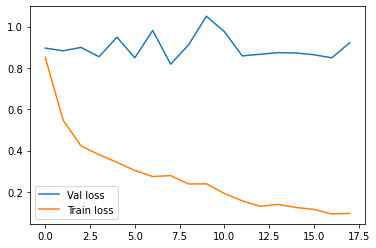

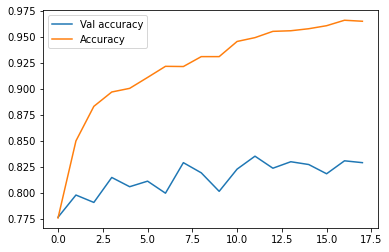

In [6]:
it_file = open("it_history.pkl", "wb")
pickle.dump(history_it.history, it_file)
it_file.close()

plt.figure()
plt.plot(history_it.history["val_loss"], label = "Val loss")
plt.plot(history_it.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

In [7]:
# Fine-tuning the model
model = tf.keras.models.load_model(model_name_it)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft = model.fit(train_generator, epochs=5, verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = (validation_generator))

Fine-tuning model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 4)                 524292    
                                                                 
Total params: 24,112,004
Trainable params: 24,058,884
Non-trainable params: 53,120
_________________________________________________________________
None
Epoch 1/5
81/81 [==============================] - 118s 1s/step - loss: 0.2219 - accuracy: 0.9348 - val_loss: 0.9193 - val_accuracy: 0.8121 - lr: 1.0000e

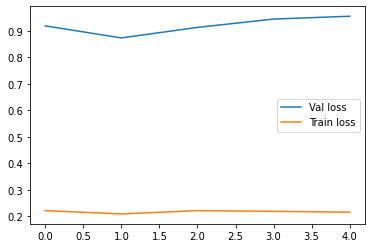

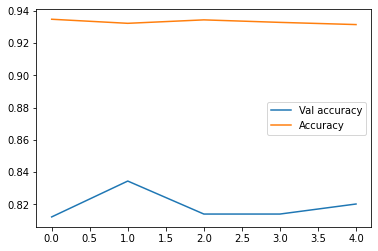

In [8]:
plt.figure()
plt.plot(history_ft.history["val_loss"], label = "Val loss")
plt.plot(history_ft.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ft.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ft.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

ft_file = open("ft_history.pkl", "wb")
pickle.dump(history_ft.history, ft_file)
it_file.close()

In [9]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = "/content/drive/MyDrive/Data/GarbageClassification/Garbage-dataset-pre-processed/Test",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 807 images belonging to 4 classes.


In [10]:
# Testing the model in the initial training
model = tf.keras.models.load_model(model_name_it)
model.evaluate(test_generator)

# Testing the model in the fine tuning
model = tf.keras.models.load_model(model_name_ft)
model.evaluate(test_generator)

13/13 [==============================] - 14s 999ms/step - loss: 1.1578 - accuracy: 0.7670


[1.1577842235565186, 0.7670384049415588]

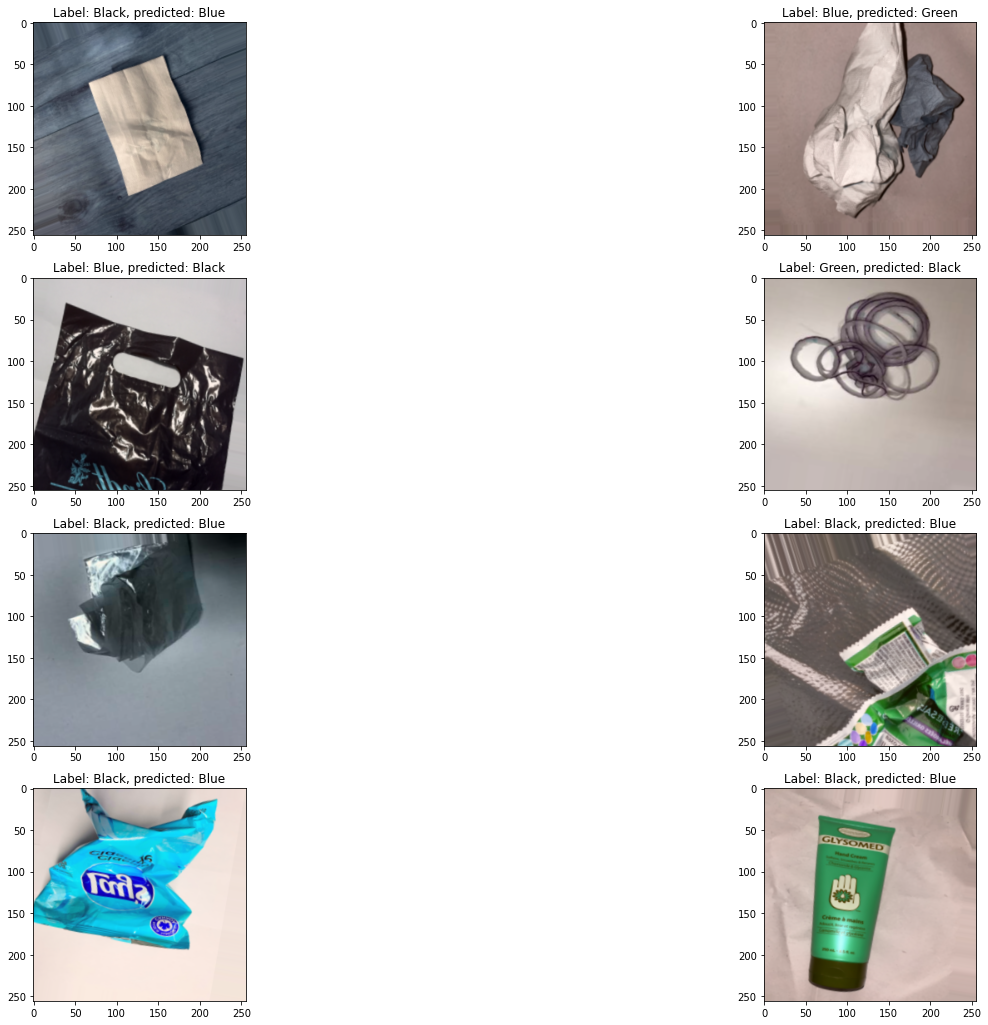

In [16]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

In [19]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

In [20]:
report = classification_report(Ytest, Ypred, target_names=class_names)
print(report)

                 precision    recall  f1-score   support

          Black       0.73      0.42      0.53        19
           Blue       0.52      0.75      0.62        16
          Green       0.83      0.94      0.88        16
Take-to-recycle       1.00      0.92      0.96        13

       accuracy                           0.73        64
      macro avg       0.77      0.76      0.75        64
   weighted avg       0.76      0.73      0.73        64



Confusion matrix, without normalization


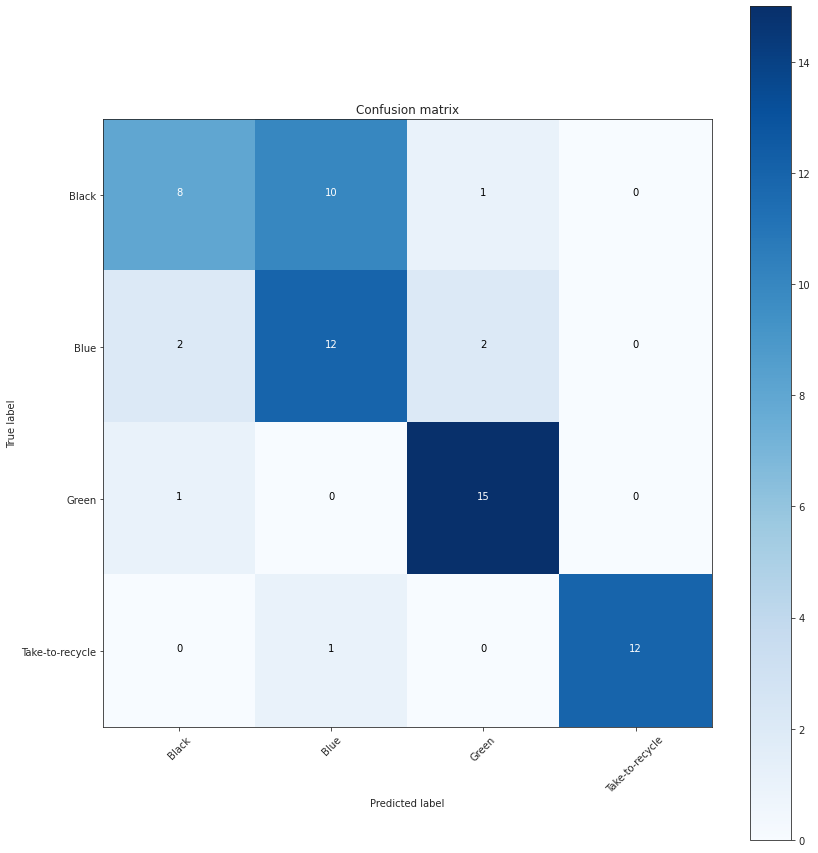

In [21]:
plot_confusion_matrix_with_default_options(Ypred, Ytest, class_names)
